In [9]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

### vgg feature analysis 

In [10]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [3]:
# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
#path_to_sketches = '../sketches'
path_to_sketches = '/home/jefan/kiddraw/analysis/museumdraw/sketches'

sketch_paths = sorted(list_files(path_to_sketches))

In [4]:
## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths)) ## includes some drawings we want to exclude (e.g. tests)

Number of sketch paths = 395


In [15]:
sketch_paths

['/home/jefan/kiddraw/analysis/museumdraw/sketches/airplane/airplane_sketch_3_E1d_1513115119771.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/airplane/airplane_sketch_4_E1d_1513364945016.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/airplane/airplane_sketch_4_E1d_1513369498187.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/airplane/airplane_sketch_5_E1d_1513204910948.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/airplane/airplane_sketch_7_E1d_1513725674858.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/apple/apple_sketch_4_E1d_1513364307492.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/apple/apple_sketch_4_E1d_1513364945016.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/apple/apple_sketch_5_E1d_1513201166943.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/apple/apple_sketch_7_E1d_1513725674858.png',
 '/home/jefan/kiddraw/analysis/museumdraw/sketches/banana/banana_sketch_10_E1c_1510684833991.png',
 '/home

## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult'`

In [11]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7','pixels']            
    F = np.load('/home/jefan/kiddraw/analysis/museumdraw/python/features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('/home/jefan/kiddraw/analysis/museumdraw/python/features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

In [12]:
## load in kid features
KF, KM = load_features('kid',7) ## pixels

KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)



array([[ 0.05150262,  0.05150262,  0.05150262, ...,  0.05915962,
         0.05170473,  0.05309668],
       [ 0.05150262,  0.05150262,  0.05150262, ...,  0.05915962,
         0.05170473,  0.05309668],
       [ 0.05150262,  0.05150262,  0.05150262, ...,  0.05915962,
         0.05170473,  0.05309668],
       ..., 
       [ 0.05150262,  0.05150262,  0.05150262, ...,  0.05915962,
         0.05170473,  0.05309668],
       [ 0.05150262,  0.05150262,  0.05150262, ...,  0.05915962,
         0.05170473,  0.05309668],
       [ 0.05150262,  0.05150262,  0.05150262, ...,  0.05915962,
         0.05170473,  0.05309668]])

### quick classification test

In [14]:
## add additional column that coarse grains age
def coarse_grain_age(row):
    if row['age'] > 6:
        val = 'older'
    elif row['age'] <= 6:
        val = 'younger'
    return val

KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)

## subset labels that have at least some drawings of them from each age category
younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
older_labels = KM[KM['coarse_age'] == 'older']['label'].values
## list of labels that are in both younger and older age categories
common_labels = list(np.intersect1d(younger_labels,older_labels))

print 'We have {} labels that are common to both younger and older kid cohorts.'.format(len(common_labels))

def subset_labels(F,M, labels):
    '''
    if labels == common_labels, then only include labels that are common to younger and older cohort
    if labels == sufficient_data_labels, then subset by list of labels in which we have 'sufficient data', i.e., have >=thresh drawings/class
    '''
    _F = F[M['label'].isin(labels),:]
    _M = M[M['label'].isin(labels)]
    return _F, _M

## get list of labels in which we have 'sufficient data', i.e., have >=5 drawings/class
thresh = 3
sufficient_data_labels = [] 
for cl in common_labels:
    num_young_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='younger')[0])
    num_older_sketches = len(np.where(KM[KM.label==cl]['coarse_age'].values=='older')[0])
    if (num_young_sketches>=thresh) & (num_older_sketches>=thresh):
        sufficient_data_labels.append(cl)        
        
print 'We have {} classes with sufficient data.'.format(len(sufficient_data_labels))


We have 35 labels that are common to both younger and older kid cohorts.
We have 15 classes with sufficient data.


In [15]:
## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
KF, KM = subset_labels(KF, KM, sufficient_data_labels)
KM = KM.reset_index(drop=True)

## output final number of drawings
older=KM[KM['coarse_age'] == 'older']
younger=KM[KM['coarse_age'] == 'younger']

print 'We have {} drawings in the older cohort'.format(np.shape(older)[0])
print 'We have {} drawings in the younger cohort'.format(np.shape(younger)[0])


We have 157 drawings in the older cohort
We have 113 drawings in the younger cohort


In [16]:
## Load sets for older vs. younger children
ind = KM.index[KM['coarse_age'] == 'older']
KM_older = KM.loc[ind]
KF_older = KF[ind.tolist()]

ind2 = KM.index[KM['coarse_age'] == 'younger']
KM_younger = KM.loc[ind2]
KF_younger = KF[ind2.tolist()]

#### Analysis 1:  Classification tests

In [17]:
####  Classification test -- all children
FEAT = KF
LABELS = KM.label.values
AGES = KM.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
# clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train) # ? not used, leaving for future use
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 1
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=3)
    print("All children accuracy: %0.2f (SD = %0.2f)" % (scores.mean(), scores.std())) # not sure why multiplying by 2, reporting just SD for now
    


0.147058823529
All children accuracy: 0.13 (SD = 0.01)


In [25]:
####  Classification test -- older children
FEAT = KF_older
LABELS = KM_older.label.values
AGES = KM_older.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 1
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=3)
    print("Older children: accuracy: %0.2f (SD = %0.2f)" % (scores.mean(), scores.std())) # not sure why multiplying by 2, reporting just SD for now
    


0.560975609756
Older children: accuracy: 0.51 (SD = 0.06)


In [22]:
#### Quick classification test -- younger children
FEAT = KF_younger
LABELS = KM_younger.label.values
AGES = KM_younger.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 1
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=3)
    print("Younger children: accuracy: %0.2f (SD = %0.2f)" % (scores.mean(), scores.std())) # not sure why multiplying by 2, reporting just SD for now
    


NameError: name 'KF_younger' is not defined

In [ ]:
## Classification tests -- older vs. younger

In [29]:
# ## see how recognizability changes with age?
# scores = []
# num_samples = []
# age_range = np.arange(4,11)

# # width of moving window in # of trials    
# window_size = 4
# lb = int(min(KM.age.values))
# ub = int(max(KM.age.values))
# num_windows = ub-lb-window_size+2 ##     

# for n in np.arange(num_windows):
#     start = lb + n
#     end = lb + n + window_size
#     ind = KM.index[(KM['age'] >= start) & (KM['age'] < end)]
#     meta = KM.loc[ind]
#     subFeat = KF[ind.tolist()]

#     FEAT = subFeat
#     LABELS = meta.label.values

#     # single train/test split
#     X_train, X_test, y_train, y_test = train_test_split(
#         FEAT, LABELS, test_size=0.25, random_state=3)
#     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
# #     clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
#     print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
#     num_samples.append(len(LABELS))
#     scores.append(clf.score(X_test, y_test))
    

### Extract adult drawing features

In [19]:
## load in adult features
AF, AM = load_features('adult',7) # 7 = pixels
AF, AM = remove_practice_trials(AF, AM)
AM = AM.reset_index(drop=True)
numSampled=10 # how many exemplars per class
numClasses=np.shape(np.unique(AM.label.values))[0]

## which label set are we using? common_labels or sufficient_data_labels
these_labels = sufficient_data_labels

## set up lookup table to cover discrepancies in category label assignments
lookup = dict(zip(these_labels,these_labels))
if 'bike' in lookup.keys():
    lookup['bike'] = 'bicycle'
    
## subset adult feature matrix and metadata matrix by appropriate labelset
AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
AM = AM.reset_index(drop=True)  

0.36202220308595617

In [ ]:
## not finished -- want to get subsample to get comparable classification

# categoryFeaturesOut=np.zeros((numSampled*numClasses,np.shape(AF)[1])) 
# np.shape(categoryFeaturesOut[0:10,:])
# def get_adult_subsample(AF,AM):
#     uniqueLabels=np.unique(AM.label.values)
#     labels=AM.label.values
#     categoryFeaturesOut=np.zeros((numSampled*numClasses,np.shape(AF)[1])) 
#     print np.shape(categoryFeaturesOut)
#     for vi, v in enumerate(np.asarray(uniqueLabels)):
#         categoryFeatures # clear to be sure
#         catIndexStart=(vi)*numSampled
#         catIndexEnd=catIndexStart+numSampled
#         print catIndexStart
#         print catIndexEnd
#         randImageInd=np.random.randint(500,size=numSampled)
#         categoryFeatures=AF[labels == v,:]
#         categoryFeaturesSelected=categoryFeatures[randImageInd,:]
        
#         np.shape(categoryFeatures)
#         return categoryFeatures
#         del categoryFeatures category       

# categoryFeatures=get_adult_subsample(AF,AM)
# categoryFeatures


In [109]:
### Correlations between features in FC7 each class (e.g., object category)

In [24]:
# make general function
def corr_cohort_classes(cohort1,cohort2,uniqueLabels):
    if  np.shape(cohort1)==np.shape(cohort2): ## make sure same shape
        classCor=np.zeros(np.shape(uniqueLabels)[0]) # open variable
        for vi, v in enumerate(np.asarray(uniqueLabels)):
            cohort1Vec = cohort1[uniqueLabels == v,:]
            cohort2Vec = cohort2[uniqueLabels == v,:]
            cohort1Vec=np.reshape(cohort1Vec,np.shape(cohort1Vec)[1],np.shape(cohort1Vec)[0]) # resahpe for corr
            cohort2Vec=np.reshape(cohort2Vec,np.shape(cohort2Vec)[1],np.shape(cohort2Vec)[0])# resahpe for corr
            classCor[vi]=stats.pearsonr(cohort1Vec,cohort2Vec)[0]
        return classCor
    
uniqueLabels=np.unique(KM.label.values)
means_adult = get_class_means(AF, AM.label.values)
means_kid = get_class_means(KF, KM.label.values)
classCor=corr_cohort_classes(means_adult,means_kid,np.unique(KM.label.values))
sortInd=np.argsort(classCor)
print uniqueLabels[sortInd]
print classCor[sortInd]

['boat' 'shoe' 'cup' 'car' 'couch' 'train' 'frog' 'foot' 'carrot' 'rabbit'
 'ice cream' 'phone' 'banana' 'flower' 'chair']
[ 0.09165147  0.16026777  0.30934528  0.31321119  0.34329901  0.43240504
  0.51011855  0.51139082  0.55248657  0.63200355  0.64307664  0.64705823
  0.67628643  0.73015292  0.73327501]


In [60]:
means_older = get_class_means(KF_older, KM_older.label.values)
means_younger = get_class_means(KF_younger, KM_younger.label.values)


In [61]:
classCor_Younger=corr_cohort_classes(means_adult,means_younger,np.unique(KM.label.values))
sortIndYounger=np.argsort(classCor_Younger)

classCor_Older=corr_cohort_classes(means_adult,means_older,np.unique(KM.label.values))
sortIndOlder=np.argsort(classCor_Older)

df = pd.DataFrame({
    'Labels-Older':  uniqueLabels[sortIndOlder],
    'Correlations-Older': classCor_Older[sortIndOlder],
    'Labels-Younger': uniqueLabels[sortIndYounger],
    'Correlations-Younger': classCor_Younger[sortIndYounger],
    'Labels-AllKids':uniqueLabels[sortInd],
    'Correlations-AllKids':classCor[sortInd],
})
df.to_csv('FeatureCorrelationsByClass.csv') # save for me to load into R!

In [63]:
df

,Correlations-AllKids,Correlations-Older,Correlations-Younger,Labels-AllKids,Labels-Older,Labels-Younger
0,0.098041,0.195618,-0.055975,shoe,shoe,shoe
1,0.260849,0.217590,0.044860,boat,cup,boat
2,0.317210,0.278706,0.069394,bird,bird,frog
3,0.342855,0.374891,0.208123,cup,boat,couch
4,0.397598,0.410975,0.272994,couch,couch,bird
5,0.486277,0.418847,0.308742,train,train,carrot
6,0.487718,0.474007,0.349682,frog,foot,foot
7,0.550594,0.544457,0.423443,foot,ice cream,car
8,0.565374,0.573780,0.444732,car,car,banana
9,0.651538,0.597500,0.448650,banana,frog,flower


In [216]:
### Representational Similarity Analyses

In [28]:
## apply clustering to organize RDM so that we can see some block diagonal structure
def flatten(x):
    return [item for sublist in x for item in sublist]

## retrieve alpha sorted labels from meta
_labels = np.unique(AM.label.values)
means = get_class_means(AF, AM.label.values)
af = AffinityPropagation(damping=0.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs))

# define standard order to be used for RDM's across layers
standard_order = ordered_objs

## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

Clusters
['car' 'couch' 'train']
['boat' 'ice cream']
['carrot' 'flower' 'frog' 'phone' 'rabbit']
['banana' 'chair' 'cup' 'foot' 'shoe']


NameError: name 'ordered_objs' is not defined

In [31]:
def get_and_plot_RDM(M,F,cohort,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]
    sns.set_style('white')
    CORRMAT = np.corrcoef(ordered_means)

    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(1-CORRMAT, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    RDM = CORRMAT
    plt.gcf().subplots_adjust(left=0.5)
    plt.savefig('./plots/RDM_{}.pdf'.format(cohort))
    
    return RDM


def get_RDM(M,F,sort_inds):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:]    
    RDM = np.corrcoef(ordered_means)
    return RDM

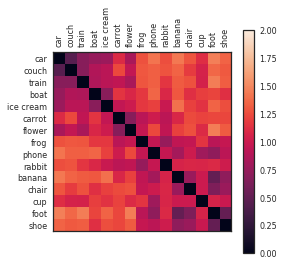

In [32]:
## get and plot sorted adult RDM
ARDM = get_and_plot_RDM(AM, AF,'adult',sort_inds)

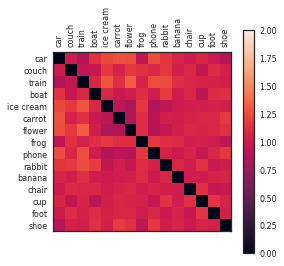

In [33]:
## get and plot sorted kid RDM collapsing across all ages
KRDM = get_and_plot_RDM(KM, KF,'kid',sort_inds)

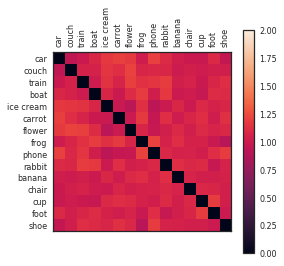

In [35]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
ORDM = get_and_plot_RDM(meta, feat,'older',sort_inds)

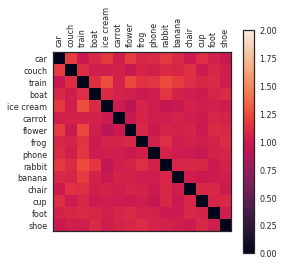

In [36]:
## get RDM for younger kids (3,4,5,6)
ind = KM.index[KM['coarse_age'] == 'younger']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
YRDM = get_and_plot_RDM(meta, feat,'younger',sort_inds)

In [37]:
## print pixelwise cross-cohort correlations

dim = KRDM.shape[0]
cor = stats.spearmanr(np.ravel(KRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and overall kid RDM: {}'.format(cor)
print ' '
dim = ORDM.shape[0]
cor = stats.spearmanr(np.ravel(ORDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and OLDER kid RDM: {}'.format(cor)
print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ARDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between adult and YOUNGER kid RDM: {}'.format(cor)
print ' '
dim = YRDM.shape[0]
cor = stats.spearmanr(np.ravel(YRDM[np.triu_indices(dim,k=1)]),np.ravel(ORDM[np.triu_indices(dim,k=1)]))[0]
print 'Correlation between OLDER and YOUNGER kid RDM: {}'.format(cor)

Correlation between adult and overall kid RDM: 0.0685154468173
 
Correlation between adult and OLDER kid RDM: 0.0183599419448
 
Correlation between adult and YOUNGER kid RDM: 0.0644930541157
 
Correlation between OLDER and YOUNGER kid RDM: 0.27337756583


In [39]:
round(0.0644930541157,2)
round(0.0183599419448,2)

0.02

### generalize across layers

In [75]:
## which label set are we using? common_labels or sufficient_data_labels
these_labels = sufficient_data_labels

## function to apply various cleanup operations to adult feat/meta, including deborkifying and subsetting by appropriate labelset
def adult_preproc(AF, AM, these_labels):
    ## set up lookup table to cover discrepancies in category label assignments
    lookup = dict(zip(these_labels,these_labels))
    if 'bike' in lookup.keys():
        lookup['bike'] = 'bicycle'

    ## subset adult feature matrix and metadata matrix by appropriate labelset
    AF, AM = subset_labels(AF, AM, [lookup[i] for i in these_labels])
    AM = AM.reset_index(drop=True)    
    return AF, AM

## function to add coarse grain age and subset according to proper labelset
def preproc_kid(KF, KM,these_labels):    
    KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)
    ## subset labels that have at least some drawings of them from each age category
    younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
    older_labels = KM[KM['coarse_age'] == 'older']['label'].values
    
    ## subset to only use the labels with either COMMON LABELS or SUFFICIENT DATA (see cell above)
    KF, KM = subset_labels(KF, KM, these_labels)
    KM = KM.reset_index(drop=True)    
    return KF, KM

## make sure directory for RDM exists
if not os.path.exists('./rdm'):
    os.makedirs('./rdm')

##### generate and save out RDMs as separate npy files

In [38]:
## load in adult features
really_run = 0
if really_run:
    for layer_num in np.arange(7):
        print 'Loading in adult features for layer {}...'.format(layer_num)
        AF, AM = load_features('adult',layer_num)
        AF, AM = remove_practice_trials(AF, AM)
        AM = AM.reset_index(drop=True)
        AF, AM = adult_preproc(AF, AM, these_labels)
        print 'Shape of adult feature tensor: {}'.format(np.shape(AF))

        ## get RDM
        cohort = 'adult'
        print 'Getting and saving RDM...'
        RDM = get_RDM(AM, AF,sort_inds)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),ARDM)
        
    print 'All done!'

In [106]:
really_run = 0
lb = 0
ub = 7
if really_run:
    ## loop through all kid layers and save out their RDM
    for layer_num in np.arange(lb,ub):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
        print 'Shape of kid feature tensor: {}'.format(np.shape(KF))

        ## get RDM
        print 'Getting and saving RDM...'
        cohort = 'kid'
        KRDM = get_RDM(KM, KF,sort_inds)
        ## save out RDM as npy
        np.save('./rdm/RDM_{}_{}.npy'.format(cohort,layer_num),KRDM)
        
        print 'Saved OVERALL KID RDMs for layer {}!'.format(layer_num)        
                
    ## loop through all kid layers and save out their RDM
    for layer_num in np.arange(lb,ub):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)

        ## get RDM for older kids (7,8,9,10)
        ind = KM.index[KM['coarse_age'] == 'older']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        print 'Shape of older kid feature tensor: {}'.format(np.shape(feat))        
        ORDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('older',layer_num),ORDM)            
        print 'Saved OLDER KID RDMs for layer {}!'.format(layer_num)        
            
    for layer_num in np.arange(lb,ub):
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
                
        ## get RDM for younger kids (3,4,5,6)            
        ind = KM.index[KM['coarse_age'] == 'younger']
        meta = KM.loc[ind]
        feat = KF[ind.tolist()]
        print 'Shape of younger kid feature tensor: {}'.format(np.shape(feat))                
        YRDM = get_RDM(meta, feat,sort_inds)
        np.save('./rdm/RDM_{}_{}.npy'.format('younger',layer_num),YRDM)             

        print 'Saved YOUNGER KID RDMs for layer {}!'.format(layer_num)
                

##### plot layer-wise cross-cohort similarity

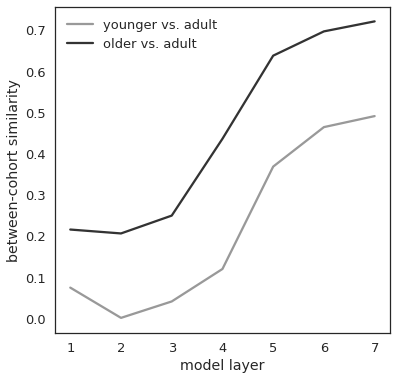

In [425]:
corOA = []
corYA = []

for layer_num in np.arange(7):
    Y = np.load('./rdm/RDM_younger_{}.npy'.format(layer_num))
    O = np.load('./rdm/RDM_older_{}.npy'.format(layer_num))
    A = np.load('./rdm/RDM_adult_{}.npy'.format(layer_num))

    dim = O.shape[0]
    rOA = stats.spearmanr(np.ravel(O[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]
    rYA = stats.spearmanr(np.ravel(Y[np.triu_indices(dim,k=1)]),np.ravel(A[np.triu_indices(dim,k=1)]))[0]

    corOA.append(rOA)
    corYA.append(rYA)


import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))
plt.plot(np.arange(1,8),corYA,label='younger vs. adult',color=(0.6,0.6,0.6))
plt.plot(np.arange(1,8),corOA,label='older vs. adult',color=(0.2,0.2,0.2))
plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
plt.legend()
plt.savefig('./plots/btw_cohort_similarity.pdf')

### get errorbars for cross-cohort similarity plot (jackknife resampling over classes)

In [102]:
def get_RDM_resampled(M,F,sort_inds,iteration):
    ## sorted adult RDMs
    labels = M.label.values
    means = get_class_means(F, labels)
    ordered_means = means[sort_inds,:] 
    ### JACKKNIFE RESAMPLING OVER CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
    # 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
    # 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
    #          where x.i = (1/n) * Sum(xi), the average of all subsamples    
    jacks = np.roll(range(ordered_means.shape[0]),iteration)[:ordered_means.shape[0]-1]
    ordered_means = ordered_means[jacks,:]
    RDM = np.corrcoef(ordered_means)
    return RDM

def get_rdm_similarity(A,B):
    '''
    A is RDM for one population
    B is RDM for another population, of same dimensionality
    '''
    dim = A.shape[0]
    return stats.spearmanr(np.ravel(A[np.triu_indices(dim,k=1)]),np.ravel(B[np.triu_indices(dim,k=1)]))[0]

In [ ]:
lb = 0
ub = 7
nIter = len(these_labels)

cohorts = ['younger','older']
CORMAT = []
for cohort in cohorts:
    ## loop through all kid layers and save out their RDM
    Cormat = [] ## cohort-level grouping of cross-cohort similarity
    for layer_num in np.arange(lb,ub):
        print 'Loading in kid features for layer {}...'.format(layer_num)    
        ## load in kid features
        KF, KM = load_features('kid',layer_num)
        KF, KM = remove_practice_trials(KF, KM)
        KM = KM.reset_index(drop=True)
        KF, KM = preproc_kid(KF, KM, these_labels)
        print 'Shape of kid feature tensor: {}'.format(np.shape(KF))    

        print 'Loading in adult features for layer {}...'.format(layer_num)
        AF, AM = load_features('adult',layer_num)
        AF, AM = remove_practice_trials(AF, AM)
        AM = AM.reset_index(drop=True)
        AF, AM = adult_preproc(AF, AM, these_labels)
        print 'Shape of adult feature tensor: {}'.format(np.shape(AF)) 

        ## get older kid RDM
        print 'Getting and saving kid and adult RDMs ...'
        KRDM = []
        ARDM = []
        cormat = [] ## layer-level grouping of cross-cohort similarity
        for i in range(nIter):
            if i%4==0:
                print 'Iteration {} of {}'.format(i,nIter)
            ## get RDM for this cohort, i.e., {'older', 'younger'}
            ind = KM.index[KM['coarse_age'] == cohort]
            meta = KM.loc[ind]
            feat = KF[ind.tolist()]                    
            krdm = get_RDM_resampled(meta, feat,sort_inds,i)
            ## get RDM adult for adults, aggregate across iterations
            ardm = get_RDM_resampled(AM, AF,sort_inds,i)        
            if len(KRDM)==0:
                KRDM = krdm
                ARDM = ardm
            else:
                KRDM = np.dstack((KRDM,krdm))
                ARDM = np.dstack((ARDM,ardm))                                  
            ## compute similarity between RDMs
            cormat.append(get_rdm_similarity(krdm,ardm))
        ## layer level aggregation    
        Cormat.append(cormat)
        KRDM = np.array(KRDM)
        ARDM = np.array(ARDM)
        np.save('./rdm/RDM_jackknife_{}_{}.npy'.format(cohort,layer_num),KRDM)             
        np.save('./rdm/RDM_jackknife_{}_{}.npy'.format('adult',layer_num),ARDM)         
    ## cohort level aggregation    
    CORMAT.append(Cormat)
                      

Loading in kid features for layer 0...
Shape of kid feature tensor: (279, 802816)
Loading in adult features for layer 0...
Shape of adult feature tensor: (8000, 802816)
Getting and saving kid and adult RDMs ...
Iteration 0 of 16
Iteration 4 of 16
Iteration 8 of 16
Iteration 12 of 16
Loading in kid features for layer 1...
Shape of kid feature tensor: (279, 401408)
Loading in adult features for layer 1...
Shape of adult feature tensor: (8000, 401408)
Getting and saving kid and adult RDMs ...
Iteration 0 of 16
Iteration 4 of 16
Iteration 8 of 16


In [155]:
## save CORMAT 
CORMAT = np.array(CORMAT)
np.save('./rdm/CORMAT.npy',CORMAT)

In [160]:
## CORMAT has dimensionality: num_cohorts x num_layers x num_objects
np.shape(np.array(CORMAT))
### JACKKNIFE RESAMPLING OVER CLASSES (https://en.wikipedia.org/wiki/Jackknife_resampling)    
# 1: exhaustively subset 15 of 16 categories, and compute cross-domain similarity in each case
# 2: variance estimate = (n-1)/n  *   Sum([xi - x.i]^2)
#          where x.i = (1/n) * Sum(xi), the average of all subsamples 
cohorts = ['younger','older']
SEM_JACK = []
for c,cohort in enumerate(cohorts):
    sem_jack = []
    for layer_num in np.arange(7):
        jackvals = CORMAT[c,layer_num,:]
        jackmean = np.mean(jackvals)
        sem_jack.append(np.sqrt((15/16) * np.array([(i-jackmean)**2 for i in jackvals]).sum()))
    SEM_JACK.append(sem_jack)
SEM_JACK = np.array(SEM_JACK)

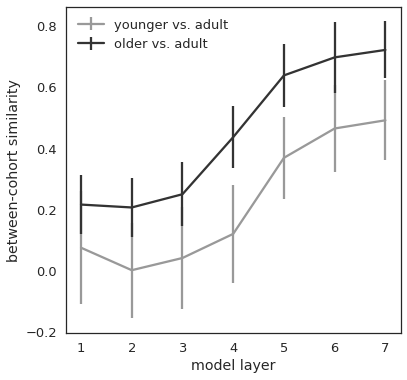

In [164]:
## dimensionality of SEM_JACK is num_cohorts x num_layers
sem_ya = SEM_JACK[0,:]
sem_oa = SEM_JACK[1,:]
import seaborn as sns
sns.set_context('talk')
sns.set_style('white')
plt.figure(figsize=(6,6))
h = plt.errorbar(np.arange(1,8),corYA,yerr=[sem_ya,sem_ya], color=[0.6, 0.6, 0.6], ecolor=[0.6, 0.6, 0.6],label='younger vs. adult')
h = plt.errorbar(np.arange(1,8),corOA,yerr=[sem_oa,sem_oa], color=[0.2, 0.2, 0.2], ecolor=[0.2, 0.2, 0.2],label='older vs. adult')
plt.xlabel('model layer')
plt.ylabel('between-cohort similarity')
plt.legend()
plt.savefig('./plots/btw_cohort_similarity.pdf')

In [431]:
## save out cohort similarity csv
df = pd.DataFrame({
    'CorrYoungAdult':  corYA,
    'SEMYoungAdult':sem_ya,
    'CorrOldAdult':  corOA,
    'SEMOldAdult':  sem_oa,
})
df.to_csv('./rdm/CohortSimilarity.csv') 

In [ ]:
### notes 1/22/18:
## preprocessing -- bounding box, remove drawings that have 0 mean pixel intensity, have text in them
  ## make invalid sketches file
## make human vs. model confusion matrix?
## make adult -- grab 5 per class "split-half" reliability -- but can actually just take two wholes, and correlate them
## estimate kids' variability -- within-class as well as across class.

In [ ]:
## How many sketches do we have from each class in kids? Take this number, divide by 2, to get approx number 
## in adults for consistency analysis. Divide by 2, because we already are dividing kid drawing dataset
## into younger and older subcategories.
YF, YM = load_features('kid',6)
kid_num_per_class = zip(np.unique(YM.label.values),np.round(YM.groupby('label').count()['age'].values/2))
knpc = dict(kid_num_per_class)

## load in adult features by layer and get internal consistency
CORR = [] ## overall 
first_layer = 0
num_layers = 7
for layer_num in np.arange(first_layer,num_layers):
    print('Layer {} of {}'.format(layer_num,num_layers))
    AF, AM = load_features('adult',layer_num)

    qats = np.unique(AM.label.values)
    Meta = [] # initialize adult subsampled metadata csv -- same for both halves
    Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
    Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half

    nIter = 30

    Cor = [] ## correlation between split RDM's
    for it in np.arange(nIter):
        if it%5==0:
            print('Iteration {} of {}'.format(it,nIter))
        for q in qats:
            ind = AM.index[AM['label'] == q]
            meta = AM.loc[ind]
            meta = meta.reset_index(drop=True)
            feat = AF[ind.tolist()]

            how_many = int(knpc[q]) ## look up approx(!) how many younger/older kid sketches we have from this class
            row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
            metasamp = meta.loc[row_inds]
            featsamp = feat[row_inds.tolist()] ## subsample first "split-half" feature mat

            row_inds_2 = np.random.RandomState(it).permutation(meta.shape[0])[how_many:how_many*2] ## get the next drawings in the permuted list
            featsamp2 = feat[row_inds_2.tolist()] ## subsample second "split-half" feature mat

            if len(Meta)==0:
                Meta = metasamp
                Feat1 = featsamp
                Feat2 = featsamp2
            else:
                Meta = pd.concat((Meta,metasamp))
                Feat1 = np.vstack((Feat1,featsamp)) 
                Feat2 = np.vstack((Feat2,featsamp2))

        ## get class means        
        Meta = Meta.reset_index(drop=True)
        means1 = get_class_means(Feat1, Meta.label.values)
        means2 = get_class_means(Feat2, Meta.label.values)

        ## get RDM for each half
        rdm1 = get_RDM(Meta,Feat1,sort_inds)
        rdm2 = get_RDM(Meta,Feat2,sort_inds)

        dim = rdm1.shape[0]
        cor = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]),np.ravel(rdm2[np.triu_indices(dim,k=1)]))[0]
        Cor.append(cor)
    CORR.append(Cor)

Layer 0 of 7


In [ ]:
CORR = np.array(CORR)
np.save('./rdm/adult_split_reliability_by_layer_nIter30.npy',CORR)

In [414]:
# ## load in adult features by layer and get internal consistency
# CORR = [] ## overall 
# first_layer = 0
# num_layers = 7
# cohorts = ['younger','older']

# for cohort in cohorts:
#     for layer_num in np.arange(first_layer,num_layers):
#         print('Layer {} of {}'.format(layer_num,num_layers))
#         KF, KM = load_features('kid',layer_num)

#         qats = np.unique(KM.label.values)
#         Meta = [] # initialize adult subsampled metadata csv -- same for both halves
#         Feat1 = [] # initialize adult subsampled feature matrix -- constitutes first half
#         Feat2 = [] # initialize adult subsampled feature matrix -- constitutes second half

#         nIter = 10

#         Cor = [] ## correlation between split RDM's
#         for it in np.arange(nIter):
#             if it%5==0:
#                 print('Iteration {} of {}'.format(it,nIter))
#             for q in qats:
#                 ind = KM.index[(KM['label'] == q) & (KM['coarse_age']==cohort)]
#                 meta = KM.loc[ind]
#                 meta = meta.reset_index(drop=True)
#                 feat = KF[ind.tolist()]

#                 how_many = np.floor(meta.shape[0]/2)

#                 row_inds = np.random.RandomState(it).permutation(meta.shape[0])[:how_many]
#                 metasamp = meta.loc[row_inds]
#                 featsamp = feat[row_inds.tolist()] ## subsample first "split-half" feature mat

#                 row_inds_2 = np.random.RandomState(it).permutation(meta.shape[0])[how_many:how_many*2] ## get the next drawings in the permuted list
#                 featsamp2 = feat[row_inds_2.tolist()] ## subsample second "split-half" feature mat

#                 if len(Meta)==0:
#                     Meta = metasamp
#                     Feat1 = featsamp
#                     Feat2 = featsamp2
#                 else:
#                     Meta = pd.concat((Meta,metasamp))
#                     Feat1 = np.vstack((Feat1,featsamp)) 
#                     Feat2 = np.vstack((Feat2,featsamp2))

#             ## get class means        
#             Meta = Meta.reset_index(drop=True)
#             means1 = get_class_means(Feat1, Meta.label.values)
#             means2 = get_class_means(Feat2, Meta.label.values)

#             ## get RDM for each half
#             rdm1 = get_RDM(Meta,Feat1,sort_inds)
#             rdm2 = get_RDM(Meta,Feat2,sort_inds)

#             dim = rdm1.shape[0]
#             cor = stats.spearmanr(np.ravel(rdm1[np.triu_indices(dim,k=1)]),np.ravel(rdm2[np.triu_indices(dim,k=1)]))[0]
#             Cor.append(cor)
#         CORR.append(Cor)

In [ ]:
# CORR = np.array(CORR)
# np.save('./rdm/kid_split_reliability_by_layer.npy',CORR)

In [415]:
## this is a (7,10) matrix that is num_layers x numIterations
x = np.load('./rdm/adult_split_reliability_by_layer.npy')

In [421]:
y = x.mean(1)

array([ 0.75664004,  0.78561706,  0.76737065,  0.80238836,  0.82811584,
        0.82625807,  0.85305299])